Please upload 'privileged_account_logs.csv' if not already created


Saving privileged_account_logs.csv to privileged_account_logs.csv

Data Sample:
              timestamp user_id          resource       action  result  \
0  2025-07-22 01:19:00  user10    db_admin_panel       logout       0   
1  2025-07-25 20:44:00  user06  user_mgmt_portal  file_delete       1   
2  2025-07-21 13:47:00  user10    db_admin_panel        login       0   
3  2025-07-21 01:52:00  user04    db_admin_panel  file_delete       1   
4  2025-07-23 18:31:00  user02    db_admin_panel  user_remove       0   

  command_executed  access_level  
0    mysql restart             5  
1  cat /etc/passwd             2  
2        chmod 777             1  
3        chmod 777             2  
4    rm -rf /tmp/*             2  

Number of anomalies detected: 30


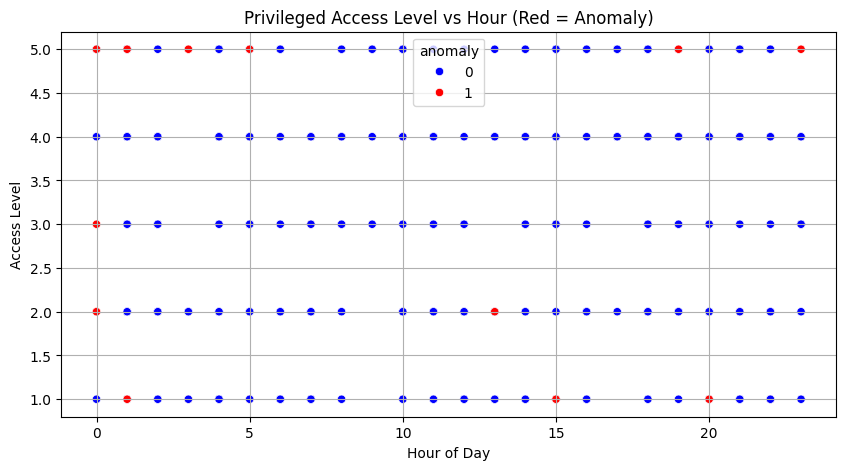

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Output saved and downloaded as 'privileged_account_anomalies.csv'


In [1]:
# ISO 27001 - Privileged Account Misuse Detection (Google Colab Compatible)

# --- Install Required Libraries (if needed) ---
# !pip install pandas numpy matplotlib seaborn scikit-learn

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import files
import io

# --- 1. Load Dataset ---
try:
    # Attempt to load user-uploaded file
    print("Please upload 'privileged_account_logs.csv' if not already created")
    uploaded = files.upload()
    df = pd.read_csv(io.BytesIO(uploaded['privileged_account_logs.csv']))
except:
    # Fallback: generate the dataset
    import random
    from datetime import datetime, timedelta
    user_ids = [f"user{i:02d}" for i in range(1, 11)]
    resources = ['firewall_console', 'db_admin_panel', 'vpn_gateway', 'user_mgmt_portal']
    actions = ['login', 'logout', 'config_change', 'file_upload', 'file_delete', 'user_add', 'user_remove']
    commands = ['sudo reboot', 'chmod 777', 'adduser temp', 'rm -rf /tmp/*', 'iptables -F', 'mysql restart', 'cat /etc/passwd']

    data = {
        "timestamp": [datetime(2025, 7, 21) + timedelta(minutes=random.randint(0, 10000)) for _ in range(300)],
        "user_id": [random.choice(user_ids) for _ in range(300)],
        "resource": [random.choice(resources) for _ in range(300)],
        "action": [random.choice(actions) for _ in range(300)],
        "result": [random.choice([0, 1]) for _ in range(300)],
        "command_executed": [random.choice(commands) for _ in range(300)],
        "access_level": [random.randint(1, 5) for _ in range(300)]
    }
    df = pd.DataFrame(data)
    df.to_csv("privileged_account_logs.csv", index=False)
    print("\nSample dataset 'privileged_account_logs.csv' created.")

print("\nData Sample:\n", df.head())

# --- 2. Preprocessing ---
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour

label_cols = ['user_id', 'resource', 'action', 'command_executed']
le_dict = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

scaler = StandardScaler()
features = ['user_id', 'resource', 'action', 'result', 'command_executed', 'access_level', 'hour']
df_scaled = scaler.fit_transform(df[features])

# --- 3. Anomaly Detection Model ---
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df['anomaly_score'] = model.fit_predict(df_scaled)
df['anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# --- 4. Visualize Anomalies ---
anomalies = df[df['anomaly'] == 1]
print("\nNumber of anomalies detected:", len(anomalies))

plt.figure(figsize=(10, 5))
sns.scatterplot(x='hour', y='access_level', hue='anomaly', data=df, palette=['blue', 'red'])
plt.title('Privileged Access Level vs Hour (Red = Anomaly)')
plt.xlabel('Hour of Day')
plt.ylabel('Access Level')
plt.grid(True)
plt.show()

# --- 5. Save and Download Results ---
output_filename = "privileged_account_anomalies.csv"
df.to_csv(output_filename, index=False)
files.download(output_filename)
print(f"\nOutput saved and downloaded as '{output_filename}'")
